<a href="https://colab.research.google.com/github/rifat01-rahman/Project-of-Python/blob/main/RRAR%2C_K_fold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting Time-Series Price Movements Using Ridge-Regularized Autoregressive Regression with K-Fold Cross-Validation.

Time–series forecasting plays a crucial role in understanding and predicting price movements in economic and financial environments. Traditional autoregressive (AR) models often suffer from instability and overfitting, especially when the underlying data exhibits noise, structural shifts, or short-term fluctuations. To address these limitations, **the Ridge-Regularized Autoregressive Regression (RRAR) approach** introduces an L2-penalty that shrinks coefficient magnitudes, improving model generalisation and reducing variance in parameter estimation.

Initially, we used the actual price values, but the data contained outliers and a very large range. As a result, even with the RRAR and K-Fold approaches, we did not achieve good performance. However, after applying the natural logarithm transformation, the model performed significantly better compared to using the original price values.

Outliers significantly influence the performance of predictive models, particularly when working with financial or price-based variables that naturally exhibit heavy tails, volatility, and structural breaks.
To improve model stability, I implemented a multi-stage outlier-handling framework that included:


- Multiple IQR thresholds (1.5×, 2.0×, 3.0×)


- Trimming approaches

- Winsorization at various percentile caps (1–99%, 2.5–97.5%)

These preprocessing strategies were evaluated alongside the RRAR and K-Fold approaches to determine their impact on predictive accuracy.

**Motivation for Using Multiple Outlier Thresholds**

Price data often suffer from:

- Wide dynamic ranges

- High kurtosis (fat tails)

- Substantial right-skewness

- Presence of extreme spikes


These distortions can degrade model performance by inflating error metrics and introducing instability.
Using multiple thresholds helps identify how sensitive the model is to outlier intensity and ensures robust comparison across methods.


**IQR-Based Outlier Detection**

- IQR Thresholds Used

To systematically test outlier strictness, I applied three levels of IQR rules:

- 1.5 × IQR (Classical Outlier Rule)

  Most sensitive

  Flags a large number of outliers

  Risk of removing many valid economic observations

- 2.0 × IQR

  More moderate

  Reduces false-positive outlier detection

- 3.0 × IQR

  Very conservative

  Only extreme deviations are treated as outliers

  More suitable for financial data with natural volatility

Using multiple IQR thresholds allowed me to understand how aggressively cleaning affects model performance and data integrity.

**Trimming vs. Winsorization**

-  Trimming

Trimming involves removing the observations that fall outside the identified IQR range.

**Findings from Trimming:**

At 1.5 × IQR, too many observations were removed → potential distortion of real data patterns.

At 2.0 × IQR, the improvement was slight but still caused nontrivial data loss.

At 3.0 × IQR, trimming removed fewer points, but the improvement remained marginal.

Main Limitation:
Trimming deletes original data, which creates a risk of losing critical information, especially in financial datasets where extreme values often represent real market behavior.

**Winsorization**

Winsorization caps extreme values instead of removing them, making it more suitable when dataset integrity must be preserved.


**Winsorization Levels Used**

I applied two winsorization strategies:

1% – 99%

Aggressive capping

Strong reduction of outlier influence

2.5% – 97.5%

More conservative

Retains more of the natural variability


**Findings from Winsorization:**

Both levels produced more stable and reliable model performance than trimming.

1–99% capping gave slightly smoother results but risked dampening real variations.

2.5–97.5% preserved more structure while still mitigating extreme distortions.

Overall, winsorization achieved a better balance by maintaining observation count and preserving the core data distribution.



**Comparative Performance Insights**

- Impact of Trimming

- Slight RMSE/MAE improvement at stricter thresholds

- Loss of important signals

- Risk of altering the true distribution

- Breaks continuity in time series

**Impact of Winsorization**


- More stable prediction performance

- Reduces influence of extreme prices without deleting data

- Preserves long-run patterns

- Consistent results across multiple thresholds

**Why Log Transformation Outperformed All**

  Even after using multiple thresholds:

- The dataset remained highly skewed

- Relationships were nonlinear

- Price variation was too large for raw-scale modeling

- Outliers still influenced the model despite capping

**The natural logarithm transformation effectively addressed these challenges by:**

- Compressing extreme values

- Stabilizing variance

- Reducing skewness

- Converting multiplicative dynamics into additive ones

- Making model assumptions more realistic


This explains why log-transformed models produced the strongest and most consistent performance across all experiments.

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

In [37]:
df = pd.read_csv('/content/HHNGSP.csv')

In [38]:
df.head()

,Date,Henry Hub Natural Gas Spot Price (Dollars per Million Btu)
0,1997-01-07,3.82
1,1997-01-08,3.80
2,1997-01-09,3.61
3,1997-01-10,3.92
4,1997-01-13,4.00


In [39]:
df= df.rename(columns={'Date':'DATE', 'Henry Hub Natural Gas Spot Price (Dollars per Million Btu)': 'price'})

In [40]:
if 'DATE' in df.columns:
    df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')  # convert, invalid parsing -> NaT
    df = df.dropna(subset=['DATE'])  # drop invalid dates
    df_t = df.set_index('DATE').sort_index()
else:
    raise KeyError("Column 'DATE' not found in DataFrame")

In [41]:
df_t.head()

,price
DATE,
1997-01-07,3.82
1997-01-08,3.80
1997-01-09,3.61
1997-01-10,3.92
1997-01-13,4.00


In [ ]:
import statsmodels.api as sm

max_lag = 12  # test up to 12 lags
bic_values = []

for lag in range(1, max_lag + 1):
    # Create lag matrix
    X_lag = pd.concat([df_t.shift(i) for i in range(1, lag + 1)], axis=1).dropna()
    y_lag = df_t.iloc[lag:]  # same length but might have misaligned index

    # Align shapes
    y_lag = y_lag.iloc[:len(X_lag)]

    model = sm.OLS(y_lag.values, sm.add_constant(X_lag.values)).fit()
    bic_values.append(model.aic)

best_lag = np.argmin(bic_values) + 1
print(f"✅ Optimal lag (by BIC): {best_lag}")


✅ Optimal lag (by BIC): 1


In [ ]:
# =========================================
# 2️⃣ CREATE LAG FEATURES (CLEAN & ALIGNED)
# =========================================

def create_lag_features(df, target_col, lags):
    series = df[target_col]
    df_lag = pd.DataFrame({'y': series})

    for i in range(1, lags + 1):
        df_lag[f'lag_{i}'] = series.shift(i)

    return df_lag.dropna().reset_index(drop=True)

# Create lagged dataset
df_lag = create_lag_features(df_t, 'price', best_lag)

# Separate predictors and target
X = df_lag.drop(columns=['y']).to_numpy()
y = df_lag['y'].to_numpy()

print(f"Lagged DataFrame shape: {df_lag.shape}")
print(f"Features used: {list(df_lag.columns[1:])}")
print(df_lag.head())

Lagged DataFrame shape: (6928, 2)
Features used: ['lag_1']
      y  lag_1
0  3.80   3.82
1  3.61   3.80
2  3.92   3.61
3  4.00   3.92
4  4.01   4.00


In [ ]:
# Configuration
# -------------------------------
alphas = np.logspace(-3, 2, 10)   # 0.001 → 100 (log scale)
n_splits = 5
test_size_ratio = 0.2
n_test = int(len(X) * test_size_ratio)

tscv = TimeSeriesSplit(n_splits=n_splits, test_size=n_test)

In [ ]:
# -------------------------------
# Cross-validation for each alpha
# -------------------------------
tuning_results = []

print("\n🔹 Ridge-Regularized AR (RRAR) — Hyperparameter Tuning\n")

for alpha in alphas:
    fold_metrics = []

    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = Ridge(alpha=alpha)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Metrics
        train_mse = mean_squared_error(y_train, y_train_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)

        fold_metrics.append({
            'train_mse': train_mse,
            'test_mse': test_mse,
            'train_r2': train_r2,
            'test_r2': test_r2
        })

    # Average across folds
    avg_train_mse = np.mean([m['train_mse'] for m in fold_metrics])
    avg_test_mse  = np.mean([m['test_mse'] for m in fold_metrics])
    avg_train_r2  = np.mean([m['train_r2'] for m in fold_metrics])
    avg_test_r2   = np.mean([m['test_r2'] for m in fold_metrics])

    tuning_results.append({
        'alpha': alpha,
        'avg_train_mse': avg_train_mse,
        'avg_test_mse': avg_test_mse,
        'avg_train_r2': avg_train_r2,
        'avg_test_r2': avg_test_r2
    })

    print(f"Alpha={alpha:<6.3f} | Train MSE={avg_train_mse:.4f} | "
          f"Test MSE={avg_test_mse:.4f} | Train R²={avg_train_r2:.4f} | Test R²={avg_test_r2:.4f}")


🔹 Ridge-Regularized AR (RRAR) — Hyperparameter Tuning

Alpha=0.001  | Train MSE=0.0624 | Test MSE=2.1043 | Train R²=0.8962 | Test R²=-0.0315
Alpha=0.004  | Train MSE=0.0624 | Test MSE=1.9462 | Train R²=0.8948 | Test R²=0.0481
Alpha=0.013  | Train MSE=0.0626 | Test MSE=1.5778 | Train R²=0.8848 | Test R²=0.2335
Alpha=0.046  | Train MSE=0.0631 | Test MSE=1.1069 | Train R²=0.8525 | Test R²=0.4706
Alpha=0.167  | Train MSE=0.0637 | Test MSE=0.8203 | Train R²=0.8153 | Test R²=0.6149
Alpha=0.599  | Train MSE=0.0640 | Test MSE=0.7152 | Train R²=0.7963 | Test R²=0.6677
Alpha=2.154  | Train MSE=0.0641 | Test MSE=0.6836 | Train R²=0.7898 | Test R²=0.6836
Alpha=7.743  | Train MSE=0.0642 | Test MSE=0.6747 | Train R²=0.7879 | Test R²=0.6881
Alpha=27.826 | Train MSE=0.0642 | Test MSE=0.6725 | Train R²=0.7873 | Test R²=0.6893
Alpha=100.000 | Train MSE=0.0647 | Test MSE=0.6755 | Train R²=0.7870 | Test R²=0.6887


In [ ]:
# Results Summary
# -------------------------------
results_df = pd.DataFrame(tuning_results)
best_alpha = results_df.loc[results_df['avg_test_mse'].idxmin(), 'alpha']

print("\n✅ Optimal alpha (based on Test MSE):", round(best_alpha, 4))
print("\nSummary:\n", results_df.round(4))


✅ Optimal alpha (based on Test MSE): 27.8256

Summary:
       alpha  avg_train_mse  avg_test_mse  avg_train_r2  avg_test_r2
0    0.0010         0.0624        2.1043        0.8962      -0.0315
1    0.0036         0.0624        1.9462        0.8948       0.0481
2    0.0129         0.0626        1.5778        0.8848       0.2335
3    0.0464         0.0631        1.1069        0.8525       0.4706
4    0.1668         0.0637        0.8203        0.8153       0.6149
5    0.5995         0.0640        0.7152        0.7963       0.6677
6    2.1544         0.0641        0.6836        0.7898       0.6836
7    7.7426         0.0642        0.6747        0.7879       0.6881
8   27.8256         0.0642        0.6725        0.7873       0.6893
9  100.0000         0.0647        0.6755        0.7870       0.6887


In [ ]:
# 4️⃣ FINAL MODEL EVALUATION (Train vs Test)
# =========================================
final_model = Ridge(alpha=best_alpha)
final_model.fit(X_train, y_train)

# Predictions
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

# Metrics
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("\n📊 Final Model Evaluation:")
print(f"Train MSE: {train_mse:.4f} | R²: {train_r2:.4f}")
print(f"Test  MSE: {test_mse:.4f} | R²: {test_r2:.4f}")


📊 Final Model Evaluation:
Train MSE: 0.0752 | R²: 0.9845
Test  MSE: 0.5185 | R²: 0.8610


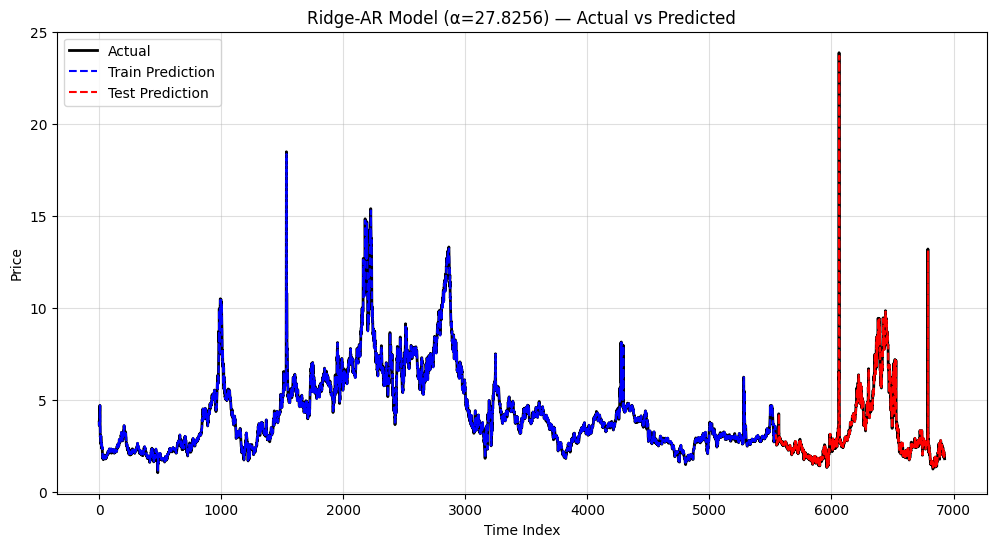

In [ ]:
# 5️⃣ VISUALIZATION
# =========================================

plt.figure(figsize=(12, 6))
plt.plot(range(len(y)), y, label='Actual', color='black', linewidth=2)
plt.plot(range(len(y_train_pred)), y_train_pred, label='Train Prediction', color='blue', linestyle='--')
plt.plot(range(len(y_train_pred), len(y)), y_test_pred, label='Test Prediction', color='red', linestyle='--')
plt.title(f'Ridge-AR Model (α={best_alpha:.4f}) — Actual vs Predicted')
plt.xlabel('Time Index')
plt.ylabel('Price')
plt.legend()
plt.grid(alpha=0.4)
plt.show()

In [ ]:
# Now I am gonna make price variable detrend then try again and objective would be reduce the overfitting

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# 1) LOG TRANSFORMATIONi
# ---------------------------------------------------
df = df_t.copy()
df['log_price'] = np.log(df['price'])
df = df.dropna()

In [ ]:
-
# ---------------------------------------------------
# 2) TRAIN / TEST SPLIT (same as before)
# ---------------------------------------------------
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size].copy()
test = df.iloc[train_size:].copy()

In [ ]:
# ----------------------------------------------------
# 3) BIC-BASED LAG SELECTION (on log_price)
# ---------------------------------------------------
max_lag = 20
bic_values = []

y_series = train['log_price']

for lag in range(1, max_lag + 1):
    df_lag = pd.DataFrame({'y': y_series})
    for i in range(1, lag + 1):
        df_lag[f'lag_{i}'] = y_series.shift(i)

    df_lag = df_lag.dropna()

    y = df_lag['y']
    X = sm.add_constant(df_lag.drop(columns=['y']))

    model_bic = sm.OLS(y, X).fit()
    bic_values.append(model_bic.bic)

best_lag = np.argmin(bic_values) + 1
print("\n✅ Best lag selected by BIC:", best_lag)


✅ Best lag selected by BIC: 3


In [ ]:
# ----------------------------------------------------
# 4) CREATE LAG FEATURES USING BEST LAG
# ---------------------------------------------------
def create_lag_features(series, lags):
    df_out = pd.DataFrame({'y': series})
    for i in range(1, lags + 1):
        df_out[f'lag_{i}'] = series.shift(i)
    return df_out.dropna()

In [ ]:
train_lag = create_lag_features(train['log_price'], best_lag)-
test_lag  = create_lag_features(test['log_price'], best_lag)

In [ ]:
X_train = train_lag.drop(columns=['y'])
y_train = train_lag['y']-

In [ ]:
X_test = test_lag.drop(columns=['y'])
y_test = test_lag['y']

In [ ]:
# ---------------------------------------------------
# 5) TUNE ALPHA USING TSCV (Pipeline with StandardScaler)
# ---------------------------------------------------
alphas = [0.001, 0.01, 0.1, 1, 5, 10, 50, 100]
tscv = TimeSeriesSplit(n_splits=5)
alpha_scores = {}

for alpha in alphas:
    mse_list = []
    for tr, te in tscv.split(X_train):
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("ridge", Ridge(alpha=alpha))
        ])

        pipe.fit(X_train.iloc[tr], y_train.iloc[tr])
        preds = pipe.predict(X_train.iloc[te])
        mse_list.append(mean_squared_error(y_train.iloc[te], preds))

    alpha_scores[alpha] = np.mean(mse_list)

best_alpha = min(alpha_scores, key=alpha_scores.get)
print("\n✅ Best Alpha Found:", best_alpha)



✅ Best Alpha Found: 0.001


In [ ]:
# ---------------------------------------------------
# 6) TRAIN FINAL MODEL
# ---------------------------------------------------
final_model = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=best_alpha))
])

final_model.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()), ('ridge', Ridge(alpha=0.001))])

In [ ]:
# ---------------------------------------------------
# 7) PREDICT (still log-price)
# ---------------------------------------------------
y_pred_train_log = final_model.predict(X_train)
y_pred_test_log  = final_model.predict(X_test)


In [ ]:
# 8) INVERSE-TRANSFORM BACK TO ORIGINAL PRICE SCALE
# ---------------------------------------------------
y_pred_train_actual = np.exp(y_pred_train_log)
y_pred_test_actual  = np.exp(y_pred_test_log)

y_train_actual = np.exp(y_train)
y_test_actual  = np.exp(y_test)

In [ ]:
# 9) PERFORMANCE METRICS
# ---------------------------------------------------
print("\n📊 MODEL PERFORMANCE (Original Price Scale)")
print("----- TRAIN -----")
print("MSE :", mean_squared_error(y_train_actual, y_pred_train_actual))
print("MAE :", mean_absolute_error(y_train_actual, y_pred_train_actual))

print("\n----- TEST -----")
print("MSE :", mean_squared_error(y_test_actual, y_pred_test_actual))
print("MAE :", mean_absolute_error(y_test_actual, y_pred_test_actual))



📊 MODEL PERFORMANCE (Original Price Scale)
----- TRAIN -----
MSE : 0.06954930404478145
MAE : 0.1288048669806011

----- TEST -----
MSE : 0.5024416823323601
MAE : 0.18634077194394427


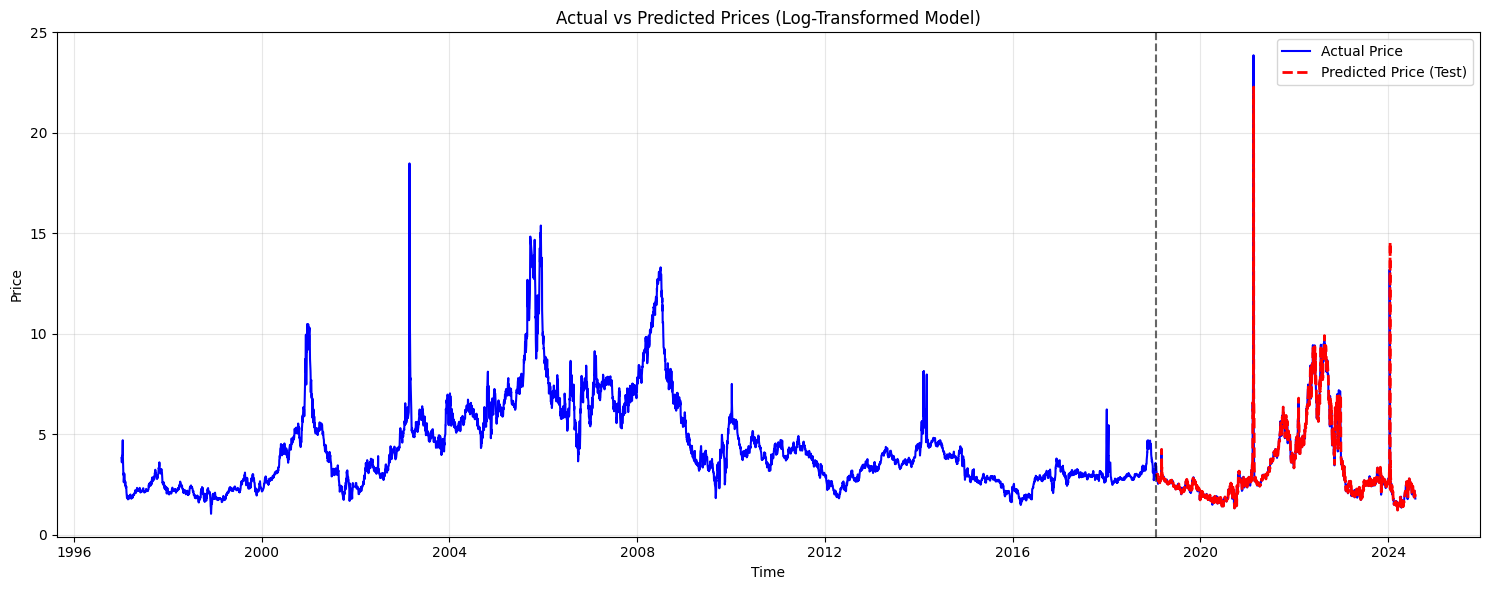

In [ ]:
# ---------------------------------------------------
# 10) PLOT: FULL ACTUAL PRICE + TEST PREDICTIONS
# ---------------------------------------------------
plt.figure(figsize=(15,6))

# actual price (full)
plt.plot(df.index, df['price'], label="Actual Price", color='blue')

# predicted price (test)
plt.plot(y_test.index, y_pred_test_actual, label="Predicted Price (Test)", linestyle='--', color='red', linewidth=2)

# mark split line
plt.axvline(df.index[train_size], linestyle='--', color='black', alpha=0.6)

plt.title("Actual vs Predicted Prices (Log-Transformed Model)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# New Strategy

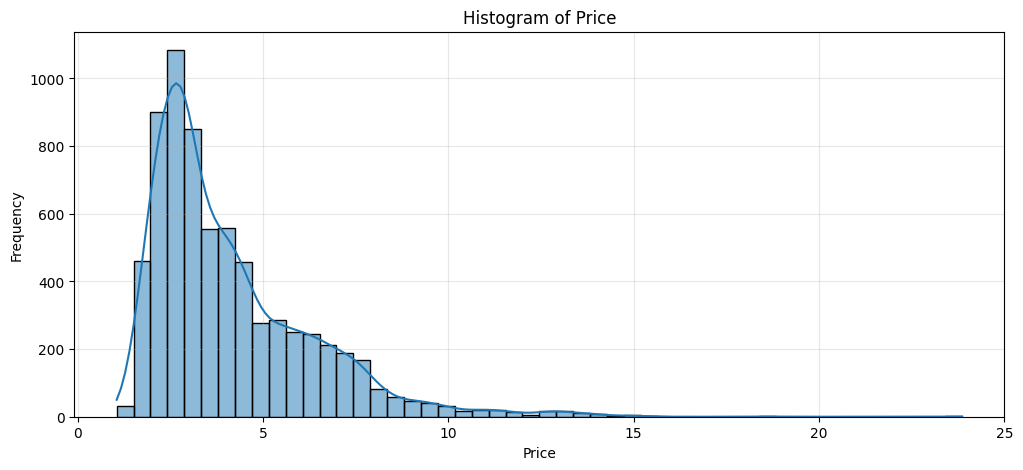

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,5))
sns.histplot(df_t['price'], bins=50, kde=True)
plt.title("Histogram of Price")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

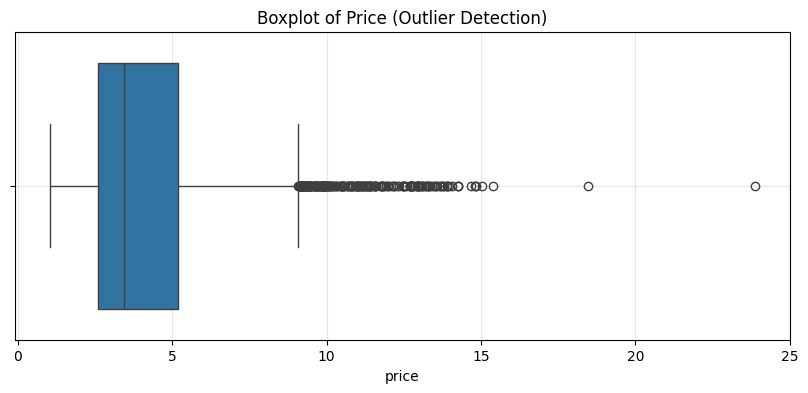

In [ ]:
plt.figure(figsize=(10,4))
sns.boxplot(x=df_t['price'])
plt.title("Boxplot of Price (Outlier Detection)")
plt.grid(alpha=0.3)
plt.show()

In [ ]:
df_t['price'].describe (include='all')

,price
count,6930.000000
mean,4.131144
std,2.184497
min,1.050000
25%,2.590000
50%,3.440000
75%,5.187500
max,23.860000


In [ ]:
# As we have skewed data, So we would use IQR method to detect outliers and trimig the values but now we are using IQR method for three values (1.5, 2, 3.0)
Q1 = df_t['price'].quantile(0.25)
Q3 = df_t['price'].quantile(0.75)
IQR = Q3 - Q1

In [ ]:
k = 1.5
lower = Q1 - k * IQR
upper = Q3 + k * IQR
trimmed_df = df_t[(df_t['price'] >= lower) & (df_t['price'] <= upper)]

In [ ]:
trimmed_df.shape

(6688, 1)

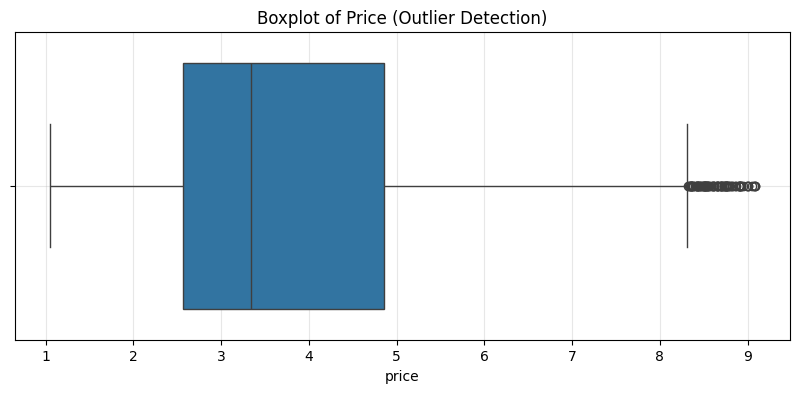

In [ ]:
# Check Outliers again
plt.figure(figsize=(10,4))
sns.boxplot(x=trimmed_df['price'])
plt.title("Boxplot of Price (Outlier Detection)")
plt.grid(alpha=0.3)
plt.show()

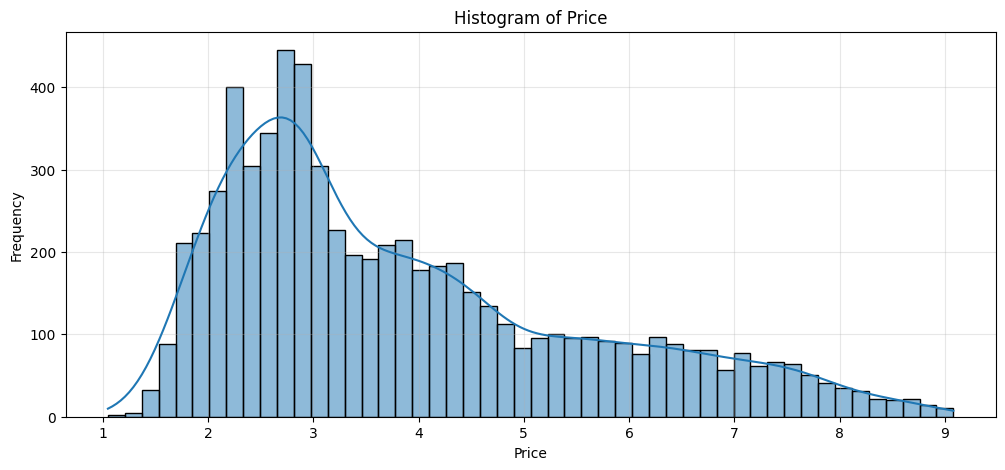

In [ ]:
plt.figure(figsize=(12,5))
sns.histplot(trimmed_df['price'], bins=50, kde=True)
plt.title("Histogram of Price")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# 1) LOG TRANSFORMATION
# ---------------------------------------------------
df = trimmed_df.copy()
df['log_price'] = np.log(df['price'])
df = df.dropna()

In [ ]:
# 2) TRAIN / TEST SPLIT (same as before)
# ---------------------------------------------------
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size].copy()
test = df.iloc[train_size:].copy()

In [ ]:
# ----------------------------------------------------
# 3) BIC-BASED LAG SELECTION (on log_price)
# ---------------------------------------------------
max_lag = 20
bic_values = []

y_series = train['log_price']

for lag in range(1, max_lag + 1):
    df_lag = pd.DataFrame({'y': y_series})
    for i in range(1, lag + 1):
        df_lag[f'lag_{i}'] = y_series.shift(i)

    df_lag = df_lag.dropna()

    y = df_lag['y']
    X = sm.add_constant(df_lag.drop(columns=['y']))

    model_bic = sm.OLS(y, X).fit()
    bic_values.append(model_bic.bic)

best_lag = np.argmin(bic_values) + 1
print("\n✅ Best lag selected by BIC:", best_lag)


✅ Best lag selected by BIC: 11


In [ ]:
# ----------------------------------------------------
# 4) CREATE LAG FEATURES USING BEST LAG
# ---------------------------------------------------
def create_lag_features(series, lags):
    df_out = pd.DataFrame({'y': series})
    for i in range(1, lags + 1):
        df_out[f'lag_{i}'] = series.shift(i)
    return df_out.dropna()

In [ ]:
train_lag = create_lag_features(train['log_price'], best_lag)
test_lag  = create_lag_features(test['log_price'], best_lag)

In [ ]:
X_train = train_lag.drop(columns=['y'])
y_train = train_lag['y']

In [ ]:
X_test = test_lag.drop(columns=['y'])
y_test = test_lag['y']

In [ ]:
# ---------------------------------------------------
# 5) TUNE ALPHA USING TSCV (Pipeline with StandardScaler)
# ---------------------------------------------------
alphas = [0.001, 0.01, 0.1, 1, 5, 10, 50, 100]
tscv = TimeSeriesSplit(n_splits=5)
alpha_scores = {}

for alpha in alphas:
    mse_list = []
    for tr, te in tscv.split(X_train):
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("ridge", Ridge(alpha=alpha))
        ])

        pipe.fit(X_train.iloc[tr], y_train.iloc[tr])
        preds = pipe.predict(X_train.iloc[te])
        mse_list.append(mean_squared_error(y_train.iloc[te], preds))

    alpha_scores[alpha] = np.mean(mse_list)

best_alpha = min(alpha_scores, key=alpha_scores.get)
print("\n✅ Best Alpha Found:", best_alpha)


✅ Best Alpha Found: 0.001


In [ ]:
# ---------------------------------------------------
# 6) TRAIN FINAL MODEL
# ---------------------------------------------------
final_model = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=best_alpha))
])

final_model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('ridge', Ridge(alpha=0.001))])

In [ ]:
# ---------------------------------------------------
# 7) PREDICT (still log-price)
# ---------------------------------------------------
y_pred_train_log = final_model.predict(X_train)
y_pred_test_log  = final_model.predict(X_test)

In [ ]:
# 8) INVERSE-TRANSFORM BACK TO ORIGINAL PRICE SCALE
# ---------------------------------------------------
y_pred_train_actual = np.exp(y_pred_train_log)
y_pred_test_actual  = np.exp(y_pred_test_log)

y_train_actual = np.exp(y_train)
y_test_actual  = np.exp(y_test)

In [ ]:
# 9) PERFORMANCE METRICS
# ---------------------------------------------------
print("\n📊 MODEL PERFORMANCE (Original Price Scale)")
print("----- TRAIN -----")
print("MSE :", mean_squared_error(y_train_actual, y_pred_train_actual))
print("MAE :", mean_absolute_error(y_train_actual, y_pred_train_actual))

print("\n----- TEST -----")
print("MSE :", mean_squared_error(y_test_actual, y_pred_test_actual))
print("MAE :", mean_absolute_error(y_test_actual, y_pred_test_actual))


📊 MODEL PERFORMANCE (Original Price Scale)
----- TRAIN -----
MSE : 0.03711848420666485
MAE : 0.11356983144603389

----- TEST -----
MSE : 0.079153623310269
MAE : 0.14653441601339875


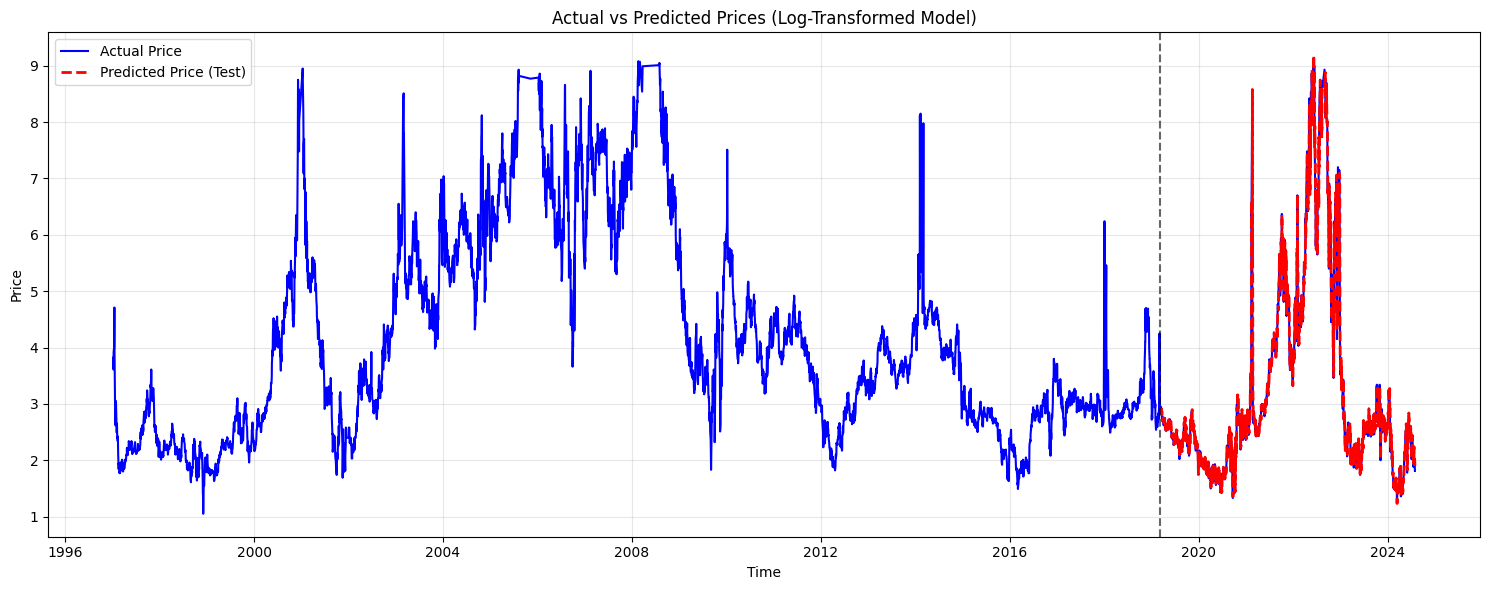

In [ ]:
# ---------------------------------------------------
# 10) PLOT: FULL ACTUAL PRICE + TEST PREDICTIONS
# ---------------------------------------------------
plt.figure(figsize=(15,6))

# actual price (full)
plt.plot(df.index, df['price'], label="Actual Price", color='blue')

# predicted price (test)
plt.plot(y_test.index, y_pred_test_actual, label="Predicted Price (Test)", linestyle='--', color='red', linewidth=2)

# mark split line
plt.axvline(df.index[train_size], linestyle='--', color='black', alpha=0.6)

plt.title("Actual vs Predicted Prices (Log-Transformed Model)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Now we are going for k = 2.0

In [ ]:
Q1 = df_t['price'].quantile(0.25)
Q3 = df_t['price'].quantile(0.75)
IQR = Q3 - Q1

In [ ]:
k = 2.0
lower = Q1 - k * IQR
upper = Q3 + k * IQR
trimmed_df = df_t[(df_t['price'] >= lower) & (df_t['price'] <= upper)]

In [ ]:
trimmed_df.shape

(6796, 1)

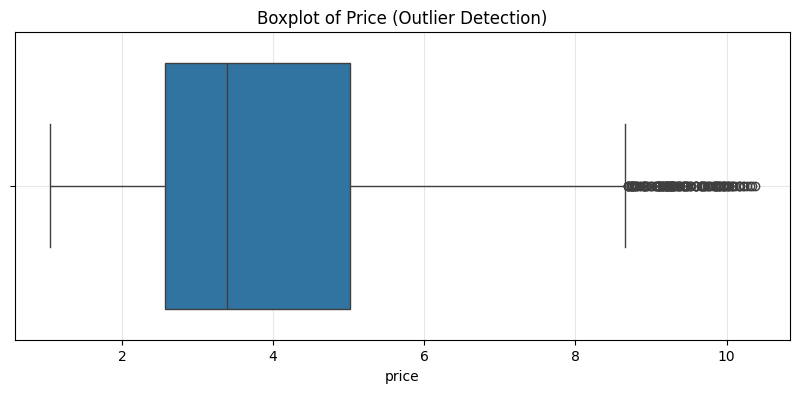

In [ ]:
# Check Outliers again
plt.figure(figsize=(10,4))
sns.boxplot(x=trimmed_df['price'])
plt.title("Boxplot of Price (Outlier Detection)")
plt.grid(alpha=0.3)
plt.show()

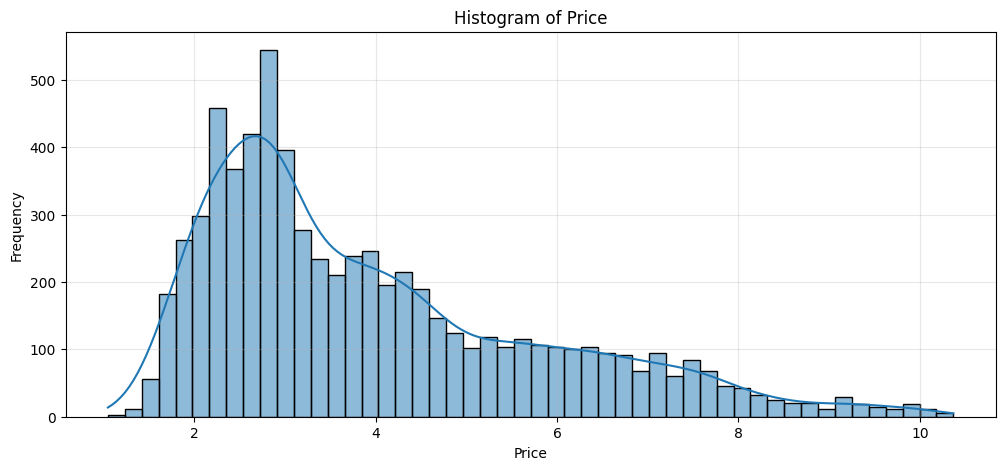

In [ ]:
plt.figure(figsize=(12,5))
sns.histplot(trimmed_df['price'], bins=50, kde=True)
plt.title("Histogram of Price")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# 1) LOG TRANSFORMATION
# ---------------------------------------------------
df = trimmed_df.copy()
df['log_price'] = np.log(df['price'])
df = df.dropna()

In [ ]:
# 2) TRAIN / TEST SPLIT (same as before)
# ---------------------------------------------------
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size].copy()
test = df.iloc[train_size:].copy()

In [ ]:
# ----------------------------------------------------
# 3) BIC-BASED LAG SELECTION (on log_price)
# ---------------------------------------------------
max_lag = 20
bic_values = []

y_series = train['log_price']

for lag in range(1, max_lag + 1):
    df_lag = pd.DataFrame({'y': y_series})
    for i in range(1, lag + 1):
        df_lag[f'lag_{i}'] = y_series.shift(i)

    df_lag = df_lag.dropna()

    y = df_lag['y']
    X = sm.add_constant(df_lag.drop(columns=['y']))

    model_bic = sm.OLS(y, X).fit()
    bic_values.append(model_bic.bic)

best_lag = np.argmin(bic_values) + 1
print("\n✅ Best lag selected by BIC:", best_lag)


✅ Best lag selected by BIC: 11


In [ ]:
# ----------------------------------------------------
# 4) CREATE LAG FEATURES USING BEST LAG
# ---------------------------------------------------
def create_lag_features(series, lags):
    df_out = pd.DataFrame({'y': series})
    for i in range(1, lags + 1):
        df_out[f'lag_{i}'] = series.shift(i)
    return df_out.dropna()

In [ ]:
train_lag = create_lag_features(train['log_price'], best_lag)
test_lag  = create_lag_features(test['log_price'], best_lag)

In [ ]:
X_train = train_lag.drop(columns=['y'])
y_train = train_lag['y']

In [ ]:
X_test = test_lag.drop(columns=['y'])
y_test = test_lag['y']

In [ ]:
# ---------------------------------------------------
# 5) TUNE ALPHA USING TSCV (Pipeline with StandardScaler)
# ---------------------------------------------------
alphas = [0.001, 0.01, 0.1, 1, 5, 10, 50, 100]
tscv = TimeSeriesSplit(n_splits=5)
alpha_scores = {}

for alpha in alphas:
    mse_list = []
    for tr, te in tscv.split(X_train):
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("ridge", Ridge(alpha=alpha))
        ])

        pipe.fit(X_train.iloc[tr], y_train.iloc[tr])
        preds = pipe.predict(X_train.iloc[te])
        mse_list.append(mean_squared_error(y_train.iloc[te], preds))

    alpha_scores[alpha] = np.mean(mse_list)

best_alpha = min(alpha_scores, key=alpha_scores.get)
print("\n✅ Best Alpha Found:", best_alpha)


✅ Best Alpha Found: 0.001


In [ ]:
# ---------------------------------------------------
# 6) TRAIN FINAL MODEL
# ---------------------------------------------------
final_model = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=best_alpha))
])

final_model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('ridge', Ridge(alpha=0.001))])

In [ ]:
# ---------------------------------------------------
# 7) PREDICT (still log-price)
# ---------------------------------------------------
y_pred_train_log = final_model.predict(X_train)
y_pred_test_log  = final_model.predict(X_test)

In [ ]:
# 8) INVERSE-TRANSFORM BACK TO ORIGINAL PRICE SCALE
# ---------------------------------------------------
y_pred_train_actual = np.exp(y_pred_train_log)
y_pred_test_actual  = np.exp(y_pred_test_log)

y_train_actual = np.exp(y_train)
y_test_actual  = np.exp(y_test)

In [ ]:
# 9) PERFORMANCE METRICS
# ---------------------------------------------------
print("\n📊 MODEL PERFORMANCE (Original Price Scale)")
print("----- TRAIN -----")
print("MSE :", mean_squared_error(y_train_actual, y_pred_train_actual))
print("MAE :", mean_absolute_error(y_train_actual, y_pred_train_actual))

print("\n----- TEST -----")
print("MSE :", mean_squared_error(y_test_actual, y_pred_test_actual))
print("MAE :", mean_absolute_error(y_test_actual, y_pred_test_actual))


📊 MODEL PERFORMANCE (Original Price Scale)
----- TRAIN -----
MSE : 0.039563269873546095
MAE : 0.11652281991774033

----- TEST -----
MSE : 0.08075607733610424
MAE : 0.14877464294571846


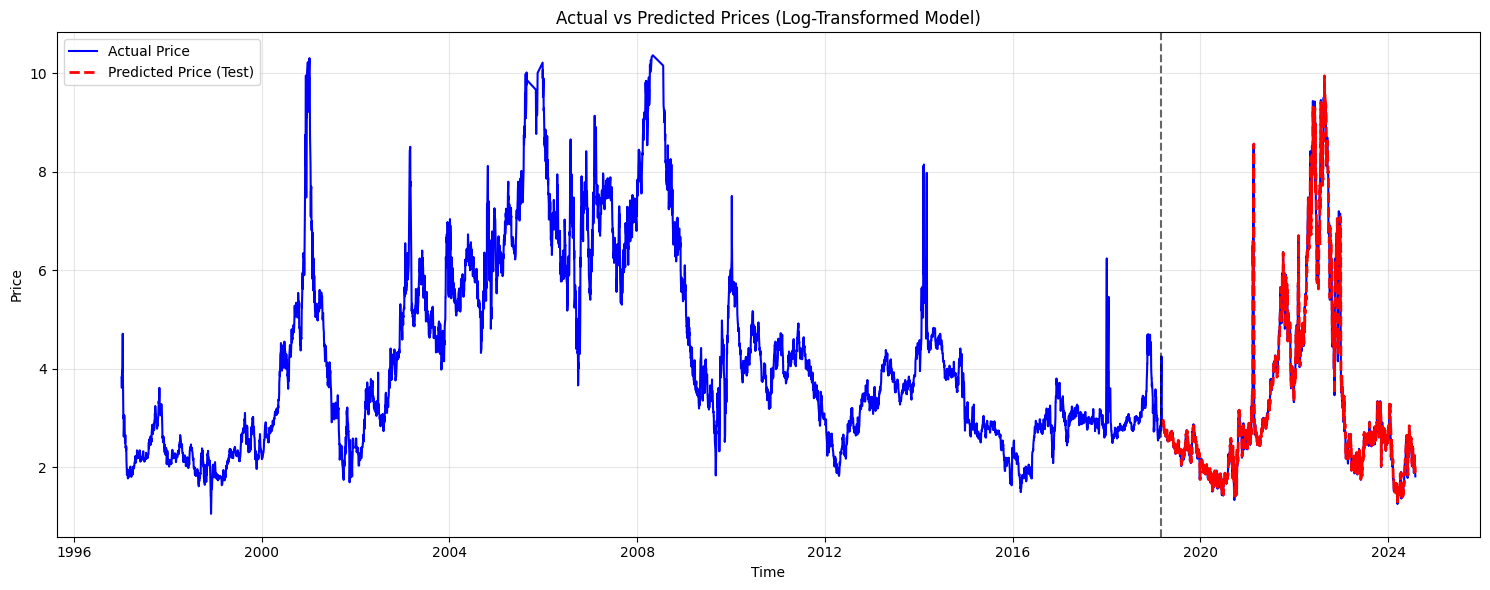

In [ ]:
# ---------------------------------------------------
# 10) PLOT: FULL ACTUAL PRICE + TEST PREDICTIONS
# ---------------------------------------------------
plt.figure(figsize=(15,6))

# actual price (full)
plt.plot(df.index, df['price'], label="Actual Price", color='blue')

# predicted price (test)
plt.plot(y_test.index, y_pred_test_actual, label="Predicted Price (Test)", linestyle='--', color='red', linewidth=2)

# mark split line
plt.axvline(df.index[train_size], linestyle='--', color='black', alpha=0.6)

plt.title("Actual vs Predicted Prices (Log-Transformed Model)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# We are using caping technique to handle the outliers

In [33]:
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
price = df_t['price']

wins_1_99 = winsorize(price, limits=[0.01, 0.01])
df_t['price_wins_1_99'] = pd.Series(wins_1_99, index=df_t.index)

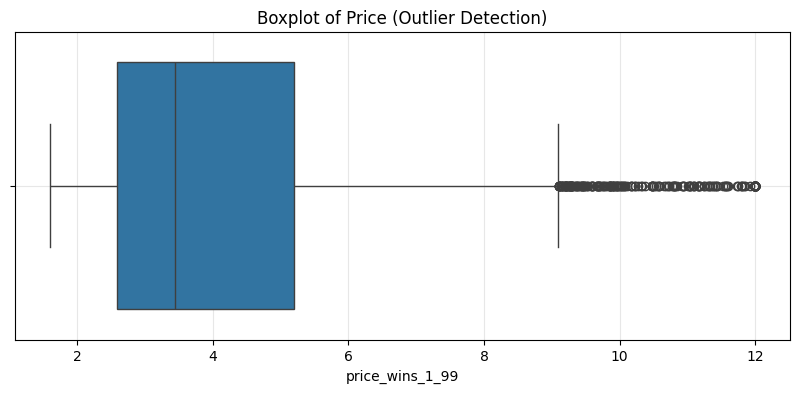

In [15]:
# Check Outliers again
plt.figure(figsize=(10,4))
sns.boxplot(x=df_t['price_wins_1_99'])
plt.title("Boxplot of Price (Outlier Detection)")
plt.grid(alpha=0.3)
plt.show()

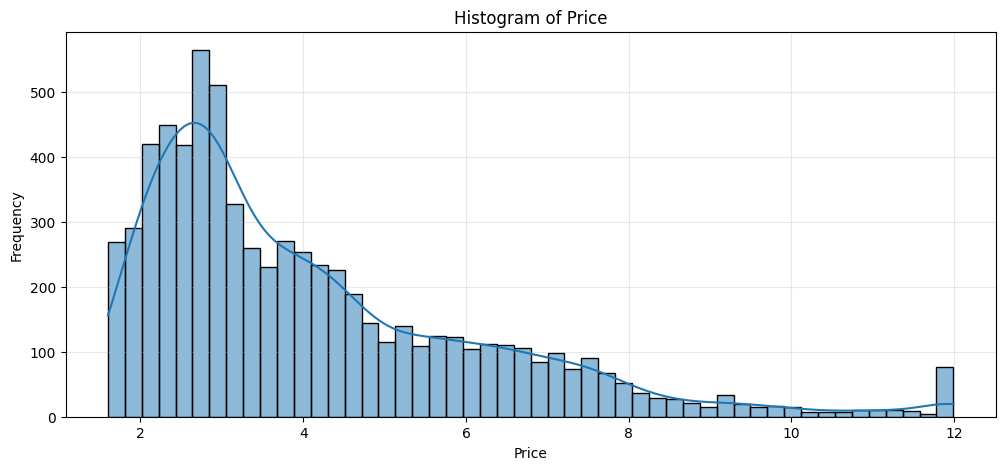

In [16]:
plt.figure(figsize=(12,5))
sns.histplot(df_t['price_wins_1_99'], bins=50, kde=True)
plt.title("Histogram of Price")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

In [18]:
# 1) LOG TRANSFORMATION
# ---------------------------------------------------
df_t['log_price'] = np.log(df_t ['price_wins_1_99'])
df_t = df_t.dropna()

In [20]:
# 2) TRAIN / TEST SPLIT (same as before)
# ---------------------------------------------------
train_size = int(len(df_t) * 0.8)
train = df_t.iloc[:train_size].copy()
test = df_t.iloc[train_size:].copy()

In [21]:
# ----------------------------------------------------
# 3) BIC-BASED LAG SELECTION (on log_price)
# ---------------------------------------------------
max_lag = 20
bic_values = []

y_series = train['log_price']

for lag in range(1, max_lag + 1):
    df_lag = pd.DataFrame({'y': y_series})
    for i in range(1, lag + 1):
        df_lag[f'lag_{i}'] = y_series.shift(i)

    df_lag = df_lag.dropna()

    y = df_lag['y']
    X = sm.add_constant(df_lag.drop(columns=['y']))

    model_bic = sm.OLS(y, X).fit()
    bic_values.append(model_bic.bic)

best_lag = np.argmin(bic_values) + 1
print("\n✅ Best lag selected by BIC:", best_lag)


✅ Best lag selected by BIC: 11


In [22]:
# ----------------------------------------------------
# 4) CREATE LAG FEATURES USING BEST LAG
# ---------------------------------------------------
def create_lag_features(series, lags):
    df_out = pd.DataFrame({'y': series})
    for i in range(1, lags + 1):
        df_out[f'lag_{i}'] = series.shift(i)
    return df_out.dropna()

In [23]:
train_lag = create_lag_features(train['log_price'], best_lag)
test_lag  = create_lag_features(test['log_price'], best_lag)

In [24]:
X_train = train_lag.drop(columns=['y'])
y_train = train_lag['y']

In [25]:
X_test = test_lag.drop(columns=['y'])
y_test = test_lag['y']

In [26]:
# ---------------------------------------------------
# 5) TUNE ALPHA USING TSCV (Pipeline with StandardScaler)
# ---------------------------------------------------
alphas = [0.001, 0.01, 0.1, 1, 5, 10, 50, 100]
tscv = TimeSeriesSplit(n_splits=5)
alpha_scores = {}

for alpha in alphas:
    mse_list = []
    for tr, te in tscv.split(X_train):
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("ridge", Ridge(alpha=alpha))
        ])

        pipe.fit(X_train.iloc[tr], y_train.iloc[tr])
        preds = pipe.predict(X_train.iloc[te])
        mse_list.append(mean_squared_error(y_train.iloc[te], preds))

    alpha_scores[alpha] = np.mean(mse_list)

best_alpha = min(alpha_scores, key=alpha_scores.get)
print("\n✅ Best Alpha Found:", best_alpha)


✅ Best Alpha Found: 0.001


In [27]:
# ---------------------------------------------------
# 6) TRAIN FINAL MODEL
# ---------------------------------------------------
final_model = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=best_alpha))
])

final_model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('ridge', Ridge(alpha=0.001))])

In [28]:
# ---------------------------------------------------
# 7) PREDICT (still log-price)
# ---------------------------------------------------
y_pred_train_log = final_model.predict(X_train)
y_pred_test_log  = final_model.predict(X_test)

In [29]:
# 8) INVERSE-TRANSFORM BACK TO ORIGINAL PRICE SCALE
# ---------------------------------------------------
y_pred_train_actual = np.exp(y_pred_train_log)
y_pred_test_actual  = np.exp(y_pred_test_log)

y_train_actual = np.exp(y_train)
y_test_actual  = np.exp(y_test)

In [30]:
# 9) PERFORMANCE METRICS
# ---------------------------------------------------
print("\n📊 MODEL PERFORMANCE (Original Price Scale)")
print("----- TRAIN -----")
print("MSE :", mean_squared_error(y_train_actual, y_pred_train_actual))
print("MAE :", mean_absolute_error(y_train_actual, y_pred_train_actual))

print("\n----- TEST -----")
print("MSE :", mean_squared_error(y_test_actual, y_pred_test_actual))
print("MAE :", mean_absolute_error(y_test_actual, y_pred_test_actual))


📊 MODEL PERFORMANCE (Original Price Scale)
----- TRAIN -----
MSE : 0.050333413387005636
MAE : 0.1211199268593071

----- TEST -----
MSE : 0.22144454181996545
MAE : 0.16286919483114196


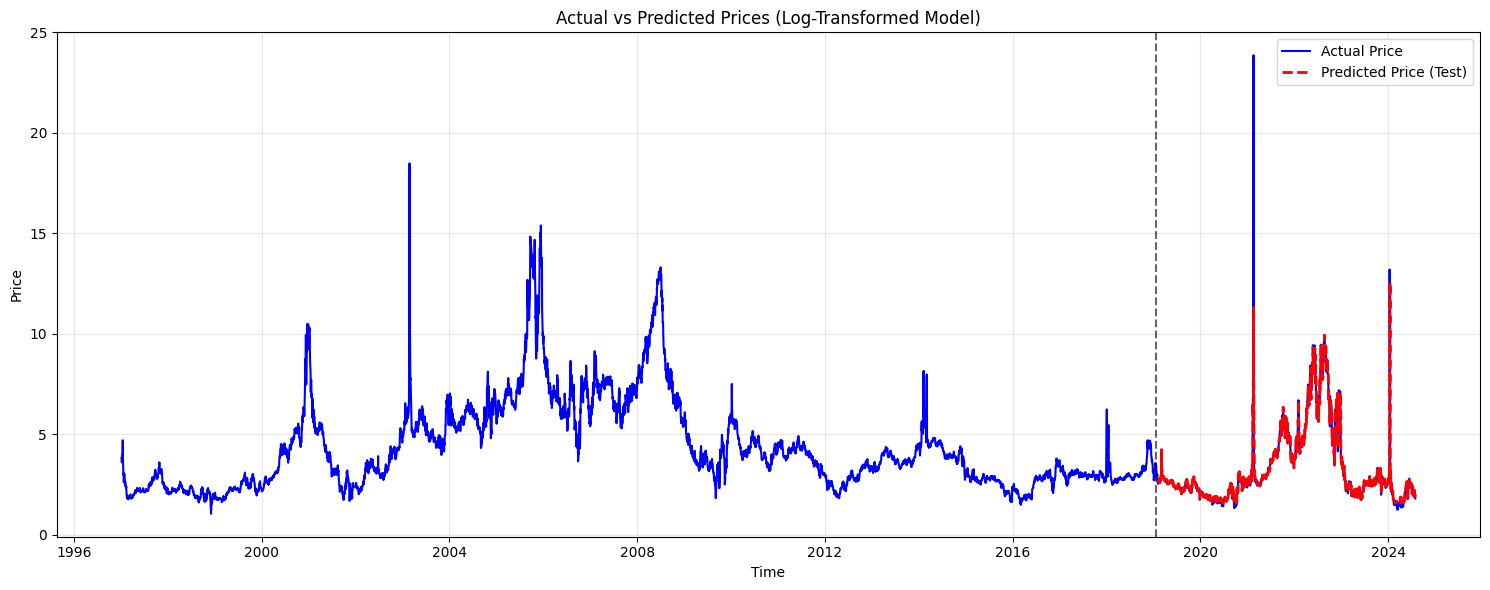

In [31]:
# ---------------------------------------------------
# 10) PLOT: FULL ACTUAL PRICE + TEST PREDICTIONS
# ---------------------------------------------------
plt.figure(figsize=(15,6))

# actual price (full)
plt.plot(df_t.index, df_t['price'], label="Actual Price", color='blue')

# predicted price (test)
plt.plot(y_test.index, y_pred_test_actual, label="Predicted Price (Test)", linestyle='--', color='red', linewidth=2)

# mark split line
plt.axvline(df_t.index[train_size], linestyle='--', color='black', alpha=0.6)

plt.title("Actual vs Predicted Prices (Log-Transformed Model)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Now, we would change the range

In [42]:
wins_2_97 = winsorize(price, limits=[0.025, 0.025])
df_t['price_wins_2_97'] = pd.Series(wins_2_97, index=df_t.index)


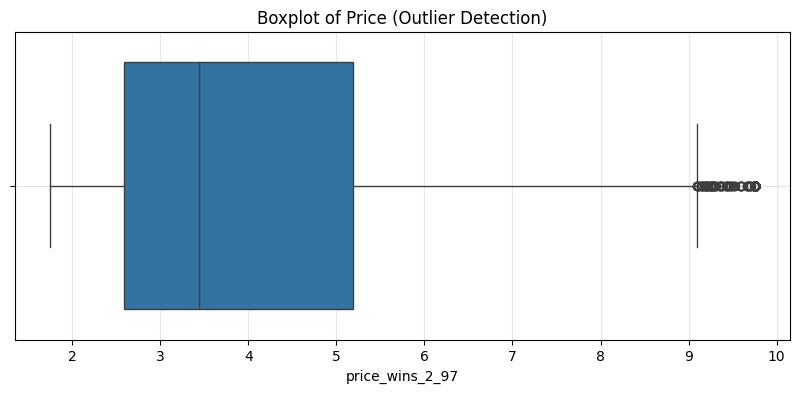

In [44]:
# Check Outliers again
plt.figure(figsize=(10,4))
sns.boxplot(x=df_t['price_wins_2_97'])
plt.title("Boxplot of Price (Outlier Detection)")
plt.grid(alpha=0.3)
plt.show()

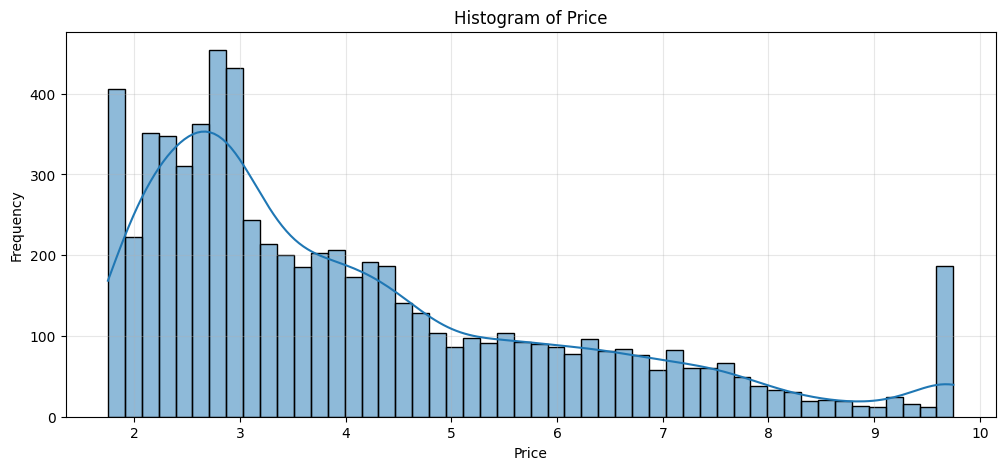

In [45]:
plt.figure(figsize=(12,5))
sns.histplot(df_t['price_wins_2_97'], bins=50, kde=True)
plt.title("Histogram of Price")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

In [46]:
# 1) LOG TRANSFORMATION
# ---------------------------------------------------
df_t['log_price'] = np.log(df_t['price_wins_2_97'])
df_t = df_t.dropna()

In [47]:
# 2) TRAIN / TEST SPLIT (same as before)
# ---------------------------------------------------
train_size = int(len(df_t) * 0.8)
train = df_t.iloc[:train_size].copy()
test = df_t.iloc[train_size:].copy()

In [48]:
# ----------------------------------------------------
# 3) BIC-BASED LAG SELECTION (on log_price)
# ---------------------------------------------------
max_lag = 20
bic_values = []

y_series = train['log_price']

for lag in range(1, max_lag + 1):
    df_lag = pd.DataFrame({'y': y_series})
    for i in range(1, lag + 1):
        df_lag[f'lag_{i}'] = y_series.shift(i)

    df_lag = df_lag.dropna()

    y = df_lag['y']
    X = sm.add_constant(df_lag.drop(columns=['y']))

    model_bic = sm.OLS(y, X).fit()
    bic_values.append(model_bic.bic)

best_lag = np.argmin(bic_values) + 1
print("\n✅ Best lag selected by BIC:", best_lag)


✅ Best lag selected by BIC: 11


In [49]:
# ----------------------------------------------------
# 4) CREATE LAG FEATURES USING BEST LAG
# ---------------------------------------------------
def create_lag_features(series, lags):
    df_out = pd.DataFrame({'y': series})
    for i in range(1, lags + 1):
        df_out[f'lag_{i}'] = series.shift(i)
    return df_out.dropna()

In [50]:
train_lag = create_lag_features(train['log_price'], best_lag)
test_lag  = create_lag_features(test['log_price'], best_lag)

In [51]:
X_train = train_lag.drop(columns=['y'])
y_train = train_lag['y']

In [52]:
X_test = test_lag.drop(columns=['y'])
y_test = test_lag['y']

In [53]:
# ---------------------------------------------------
# 5) TUNE ALPHA USING TSCV (Pipeline with StandardScaler)
# ---------------------------------------------------
alphas = [0.001, 0.01, 0.1, 1, 5, 10, 50, 100]
tscv = TimeSeriesSplit(n_splits=5)
alpha_scores = {}

for alpha in alphas:
    mse_list = []
    for tr, te in tscv.split(X_train):
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("ridge", Ridge(alpha=alpha))
        ])

        pipe.fit(X_train.iloc[tr], y_train.iloc[tr])
        preds = pipe.predict(X_train.iloc[te])
        mse_list.append(mean_squared_error(y_train.iloc[te], preds))

    alpha_scores[alpha] = np.mean(mse_list)

best_alpha = min(alpha_scores, key=alpha_scores.get)
print("\n✅ Best Alpha Found:", best_alpha)


✅ Best Alpha Found: 0.001


In [54]:
# ---------------------------------------------------
# 6) TRAIN FINAL MODEL
# ---------------------------------------------------
final_model = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=best_alpha))
])

final_model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('ridge', Ridge(alpha=0.001))])

In [55]:
# ---------------------------------------------------
# 7) PREDICT (still log-price)
# ---------------------------------------------------
y_pred_train_log = final_model.predict(X_train)
y_pred_test_log  = final_model.predict(X_test)

In [56]:
# 8) INVERSE-TRANSFORM BACK TO ORIGINAL PRICE SCALE
# ---------------------------------------------------
y_pred_train_actual = np.exp(y_pred_train_log)
y_pred_test_actual  = np.exp(y_pred_test_log)

y_train_actual = np.exp(y_train)
y_test_actual  = np.exp(y_test)

In [59]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# 9) PERFORMANCE METRICS
# ---------------------------------------------------
print("\n📊 MODEL PERFORMANCE (Original Price Scale)")

# ----- TRAIN -----
train_mse = mean_squared_error(y_train_actual, y_pred_train_actual)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train_actual, y_pred_train_actual)

print("----- TRAIN -----")
print("MSE  :", train_mse)
print("RMSE :", train_rmse)
print("MAE  :", train_mae)

# ----- TEST -----
test_mse = mean_squared_error(y_test_actual, y_pred_test_actual)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test_actual, y_pred_test_actual)

print("\n----- TEST -----")
print("MSE  :", test_mse)
print("RMSE :", test_rmse)
print("MAE  :", test_mae)



📊 MODEL PERFORMANCE (Original Price Scale)
----- TRAIN -----
MSE  : 0.03989166213166707
RMSE : 0.1997289716883033
MAE  : 0.11386507194829654

----- TEST -----
MSE  : 0.15185917807830063
RMSE : 0.3896911316392774
MAE  : 0.15262173626462036


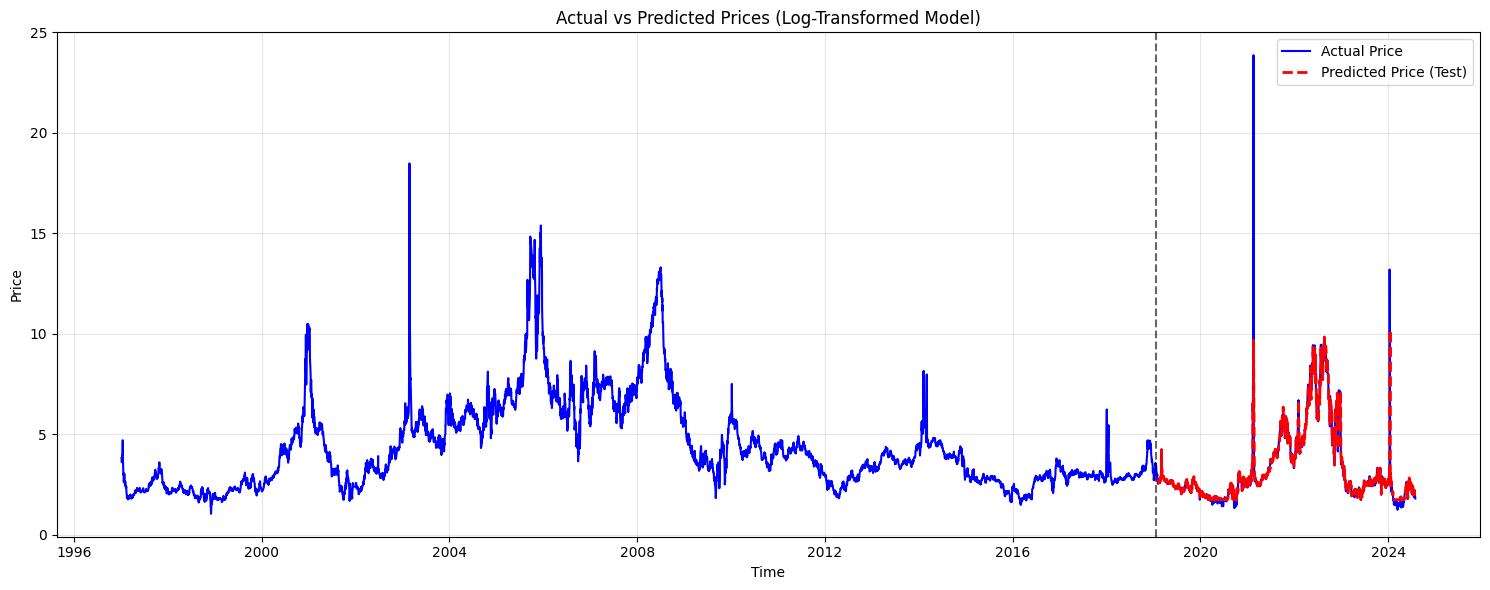

In [58]:
# ---------------------------------------------------
# 10) PLOT: FULL ACTUAL PRICE + TEST PREDICTIONS
# ---------------------------------------------------
plt.figure(figsize=(15,6))

# actual price (full)
plt.plot(df_t.index, df_t['price'], label="Actual Price", color='blue')

# predicted price (test)
plt.plot(y_test.index, y_pred_test_actual, label="Predicted Price (Test)", linestyle='--', color='red', linewidth=2)

# mark split line
plt.axvline(df_t.index[train_size], linestyle='--', color='black', alpha=0.6)

plt.title("Actual vs Predicted Prices (Log-Transformed Model)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()